In [1]:
import warnings
warnings.filterwarnings('ignore')
%pylab inline
import numpy as np
import pandas as pd

from scipy import stats
from statsmodels.stats import weightstats as wsm
from statsmodels.stats.proportion import proportion_confint

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.cm as cm

import statsmodels.api as sm
import warnings
import datetime

from sklearn.linear_model import LinearRegression

from itertools import product

from scipy.stats import spearmanr

from sklearn.cluster import KMeans, MiniBatchKMeans, AffinityPropagation
from sklearn.cluster.hierarchical import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score

from statsmodels.tsa.arima_model import ARIMAResults

Populating the interactive namespace from numpy and matplotlib


### 1. Выберите признаки

Для каждой из шести задач прогнозирования $\hat{y}_{T|T+i}, i=1,\dots,6$ сформируйте выборки. Откликом будет $y_{T+i}, i=1,\dots,6$ при всевозможных значениях $T$, а признаки можно использовать следующие:
- идентификатор географической зоны — категориальный
- год, месяц, день месяца, день недели, час — эти признаки можно пробовать брать и категориальными, и непрерывными, можно даже и так, и так
- синусы, косинусы и тренды, которые вы использовали внутри регрессионной компоненты ARIMA
- сами значения прогнозов ARIMA $\hat{y}_{T|T+i}^{ARIMA}$
- количество поездок из рассматриваемого района в моменты времени $y_{T}, y_{T-1},\dots,y_{T-K}$ (параметр $K$ можно подбирать; попробуйте начать, например, с 6)
- количество поездок из рассматриваемого района в моменты времени $y_{T-24}, y_{T-48},\dots,y_{T-24*Kd}$ (параметр $Kd$ можно подбирать; попробуйте начать, например, с 2)
- суммарное количество поездок из рассматриваемого района за предшествующие полдня, сутки, неделю, месяц
Будьте внимательны при создании признаков — все факторы должны быть рассчитаны без использования информации из будущего: при прогнозировании  $\hat{y}_{T|T+i}, i=1,\dots,6$ вы можете учитывать только значения y до момента времени T включительно.

###### 1.1 Подготавливаем массив данных, с которыми будем работать

In [2]:
%%time
# грузим майские данные, как на 2-й неделе
data5 = pd.read_csv('trips_05-2016.csv', sep=',')
# создаем фрейм - общее количество поездок такси из каждой географической зоны
reg_trip = data5.groupby(['zone']).sum().reset_index()
# вычисляем среднее кол-во поездок из каждой зоны
reg_trip_mean = data5.groupby(['zone']).mean().reset_index()

# Отфильтруем ячейки, из которых в мае совершается в среднем не менее 5 поездок в час.
# Сделаем сразу список таких ячеек
reg_more_5 = list(reg_trip_mean[reg_trip_mean.num_trips >= 5].zone)

# выгружаем остальные данные с января по июнь
data1 = pd.read_csv('trips_01-2016.csv', sep=',')
data2 = pd.read_csv('trips_02-2016.csv', sep=',')
data3 = pd.read_csv('trips_03-2016.csv', sep=',')
data4 = pd.read_csv('trips_04-2016.csv', sep=',')
data6 = pd.read_csv('trips_06-2016.csv', sep=',')

# оставляем лишь поездки из отфильтрованных ячеек
data1 = data1[data1['zone'].isin(reg_more_5)]
data2 = data2[data2['zone'].isin(reg_more_5)]
data3 = data3[data3['zone'].isin(reg_more_5)]
data4 = data4[data4['zone'].isin(reg_more_5)]
data5 = data5[data5['zone'].isin(reg_more_5)]
data6 = data6[data6['zone'].isin(reg_more_5)]

# соединяем все отфильтрованные поездки с января по июнь в один датафрейм
data = pd.concat([pd.concat([data1, data2],ignore_index=True),pd.concat([data3, data4],ignore_index=True)],ignore_index=True)
data = pd.concat([data, data5],ignore_index=True)
data = pd.concat([data, data6],ignore_index=True)

# очистим память от лишней информации
data1,data2,data3,data4,data5,data6 = 0,0,0,0,0,0
# переводим столбцы времени посадки и высадки в формат datetime и устанавливаем время в кач-ве индекса
data['time'] = pd.to_datetime(data['time'])
data.set_index('time',inplace=True)

data.tail()

Wall time: 11.1 s


zone  num_trips
time                                
2016-06-30 23:00:00  2068      147.0
2016-06-30 23:00:00  2069       38.0
2016-06-30 23:00:00  2118      173.0
2016-06-30 23:00:00  2119      119.0
2016-06-30 23:00:00  2168        0.0

###### 1.2 Формируем структуру таблиц-выборок и фрейм общих признаков для всех регионов

In [3]:
# список регионов
reg_list = np.unique(list(data.zone))

# введем временной диапазон и его длину
t = pd.date_range(start = '2016-01-15 00:00:00', end = '2016-06-30 17:00:00', freq='H')
tlen = t.shape[0]

In [4]:
# запуститм конструктор такой таблицы (придется задать "левый" столбец, потом его удалим)
uni_features = pd.DataFrame(0,index = t,columns=['fgfgfg'])
n = 168.0 # периодичность при создании гармоник-признаков
F = 25 # кол-во гармоник Фурье-разложения
# признаки синусы-косинусы
cs_cols = []
for k in range(1,F+1):
    uni_features["c" + str(k)] = np.cos(2*np.pi*k*np.arange(1, tlen+1)/n)
    uni_features["s" + str(k)] = np.sin(2*np.pi*k*np.arange(1, tlen+1)/n)
    cs_cols.append("c" + str(k))
    cs_cols.append("s" + str(k))
# признаки - дни недели (во избежании линейной зависимости со вторника по воскр)
week_cols = ["tue","wedn","thur","fri","sat","sun"]
uni_features["tue"] = [1 if date.weekday() == 1 else 0 for date in uni_features.index]
uni_features["wedn"] = [1 if date.weekday() == 2 else 0 for date in uni_features.index]
uni_features["thur"] = [1 if date.weekday() == 3 else 0 for date in uni_features.index]
uni_features["fri"] = [1 if date.weekday() == 4 else 0 for date in uni_features.index]
uni_features["sat"] = [1 if date.weekday() == 5 else 0 for date in uni_features.index]
uni_features["sun"] = [1 if date.weekday() == 6 else 0 for date in uni_features.index]
# часовые признаки (во избежании линейной зависимости с 1 по 23)
hour_cols = []
for k in range(1,24):
    uni_features["H" + str(k)] = [1 if date.hour == k else 0 for date in uni_features.index]
    hour_cols.append("H" + str(k))
# удаляем "левый столбец", использованный при создании таблицы
uni_features.drop('fgfgfg', axis=1, inplace=True)

In [153]:
#data[(data.zone == 1075) & (data.index >= T0-11*dT) & (data.index <= Tf)].num_trips.rolling(window=12).sum()[11:]
#data[(data.zone == 1075) & (data.index >= T0) & (data.index <= Tf)].num_trips.head(10)
#i = 2
#list(data[(data.zone == 1075) & (data.index >= T0+(i+1)*dT) & (data.index <= Tf+(i+1)*dT)].num_trips)

In [154]:
#features_table[0][features_table[0]["reg1075"] == 1]['reg'+str(reg_list[2])]
#features_table[0][features_table[0]["reg1075"] == 1][['yH0','yH1','yH2','yH3','yH4','yH5','yH6']]
#features_table[0][features_table[0]["reg1075"] == 1][['yD1','yD2','yD3','yD4','yD5','yD6']].head(50)
#features_table[0][features_table[0]["reg1075"] == 1][week_cols].head(50)
#features_table[0][features_table[0]["reg1075"] == 1][['H1','H2','H3','H4','H5','H6']]
#features_table[2][features_table[2]["reg1075"] == 1]['yTi']

In [5]:
%%time
K = 6  # кол-во часовых лагов
Kd = 6 # кол-во суточных лагов
T0 = datetime.datetime(2016, 1, 15)
Tf = datetime.datetime(2016, 6, 30, 17)
dT = datetime.timedelta(hours=1)

# список названий-идентификаторов регионов
reg_cols = []
for reg in reg_list:
    reg_cols.append('reg'+str(reg))

features_table = []
for i in range(6):
    print("считаем выборку ",i)
    for reg in reg_list:
        # создаем структуру для фрейма признаков текущего региона
        features = pd.DataFrame(0,index = t,columns=reg_cols)
        features.drop('reg'+str(reg), axis=1, inplace=True)
        # ставим признак идентификатора текущего региона равным 1
        features['reg'+str(reg)] = np.full(tlen, 1)
        # включаем уникальную матрицу признаков
        features = pd.concat([features, uni_features], axis=1)
        # признак - суммарное количество поездок из текущего региона за предшествующие полдня
        features['Sum12'] = data[(data.zone == reg) & (data.index >= T0-11*dT) & (data.index <= Tf)].num_trips.rolling(window=12).sum()[11:]
        # признаки по часовым лагам
        for k in range(0,K+1):
            features['yH' + str(k)] = list(data[(data.zone == reg) & (data.index >= T0-k*dT) & (data.index <= Tf-k*dT)].num_trips)
        # признаки по суточным лагам
        for k in range(1,Kd+1):
            features['yD' + str(k)] = list(data[(data.zone == reg) & (data.index >= T0-k*24*dT) & (data.index <= Tf-k*24*dT)].num_trips)
        # добавляем целевой признак y(T+i)
        features['yTi'] = list(data[(data.zone == reg) & (data.index >= T0+(i+1)*dT) & (data.index <= Tf+(i+1)*dT)].num_trips)
        if reg == reg_list[0]:
            df = features
        else:
            df = pd.concat([df, features])
    features_table.append(df)

считаем выборку  0
считаем выборку  1
считаем выборку  2
считаем выборку  3
считаем выборку  4
считаем выборку  5
Wall time: 10min 52s


In [6]:
# проверим, не осталось ли значений NaN
features_table[5].isnull().sum().sum()

0

In [7]:
features_table[0]["reg" + str(reg_list[101])].sum()

4026

### Альтернатива (отдельная модель для каждого региона)

In [42]:
%%time
K = 6  # кол-во часовых лагов
Kd = 6 # кол-во суточных лагов
T0 = datetime.datetime(2016, 1, 15)
Tf = datetime.datetime(2016, 6, 30, 17)
dT = datetime.timedelta(hours=1)

features_table = []
for i in range(6):
    print("считаем выборку ",i)
    i_features = []
    for reg in reg_list:
        # создаем структуру для фрейма
        features = pd.DataFrame(0,index = t,columns=["gggggg"])
        # включаем уникальную матрицу признаков
        features = pd.concat([features, uni_features], axis=1)
        # признак - суммарное количество поездок из текущего региона за предшествующие полдня
        features['Sum12'] = data[(data.zone == reg) & (data.index >= T0-11*dT) & (data.index <= Tf)].num_trips.rolling(window=12).sum()[11:]
        # признаки по часовым лагам
        for k in range(0,K+1):
            features['yH' + str(k)] = list(data[(data.zone == reg) & (data.index >= T0-k*dT) & (data.index <= Tf-k*dT)].num_trips)
        # признаки по суточным лагам
        for k in range(1,Kd+1):
            features['yD' + str(k)] = list(data[(data.zone == reg) & (data.index >= T0-k*24*dT) & (data.index <= Tf-k*24*dT)].num_trips)
        # добавляем целевой признак y(T+i)
        features['yTi'] = list(data[(data.zone == reg) & (data.index >= T0+(i+1)*dT) & (data.index <= Tf+(i+1)*dT)].num_trips)
        # удаляем "левый столбец", использованный при создании таблицы
        features.drop('gggggg', axis=1, inplace=True)
        # добавляем матрицу регр. признаков для текущего региона в строку 'i_features'
        i_features.append(features)
    # добавляем строку матриц регр. признаков для всех регионов в итоговый массив признаков
    features_table.append(i_features)

считаем выборку  0
считаем выборку  1
считаем выборку  2
считаем выборку  3
считаем выборку  4
считаем выборку  5
Wall time: 1min 46s


### 2. Подготовьте данные

Разбейте каждую из шести выборок на три части:
- обучающая, на которой будут настраиваться параметры моделей — всё до апреля 2016
- тестовая, на которой вы будете подбирать значения гиперпараметров — май 2016
- итоговая, которая не будет использоваться при настройке моделей вообще — июнь 2016

In [8]:
# обучающие выборки
feat_train = []
for i in range(6):
    df = features_table[i]
    feat_train.append(df[df.index <= datetime.datetime(2016, 4, 30, 17)])

In [9]:
# тестовые выборки
feat_test = []
for i in range(6):
    df = features_table[i]
    feat_test.append(df[(df.index <= datetime.datetime(2016, 5, 31, 17)) & (df.index >= datetime.datetime(2016, 4, 30, 23))])

In [10]:
# июньские выборки
feat_june = []
for i in range(6):
    df = features_table[i]
    feat_june.append(df[(df.index <= datetime.datetime(2016, 6, 30, 17)) & (df.index >= datetime.datetime(2016, 5, 31, 23))])

In [11]:
# Создадим список столбцов регрессионных признаков
regr_col = list(feat_june[0].columns)
regr_col.remove('yTi')

In [12]:
feat_test[5]["reg" + str(reg_list[101])].sum()

739

### Альтернатива (отдельная модель для каждого региона)

In [52]:
%%time
feat_train = []   # обучающие выборки, первый индекс будет i=0...5, второй - порядковый номер региона в списке reg_list 
feat_test = []    # тестовые выборки, первый индекс будет i=0...5, второй - порядковый номер региона в списке reg_list
feat_june = []    # июньские выборки, первый индекс будет i=0...5, второй - порядковый номер региона в списке reg_list
for i in range(6):
    print("i =",i)
    i_train = []
    i_test = []
    i_june = []
    for ireg in range(102):
        df = features_table[i][ireg]
        i_train.append(df[df.index <= datetime.datetime(2016, 4, 30, 17)])
        i_test.append(df[(df.index <= datetime.datetime(2016, 5, 31, 17)) & (df.index >= datetime.datetime(2016, 4, 30, 23))])
        i_june.append(df[(df.index <= datetime.datetime(2016, 6, 30, 17)) & (df.index >= datetime.datetime(2016, 5, 31, 23))])
    feat_train.append(i_train)
    feat_test.append(i_test)
    feat_june.append(i_june)

i = 0
i = 1
i = 2
i = 3
i = 4
i = 5
Wall time: 1min 28s


### 3. Выберите вашу любимую регрессионную модель и настройте её

Выберите вашу любимую регрессионную модель и настройте её на каждом из шести наборов данных, подбирая гиперпараметры на мае 2016. Желательно, чтобы модель:
- допускала попарные взаимодействия между признаками
- была устойчивой к избыточному количеству признаков (например, использовала регуляризаторы)

In [13]:
from sklearn.linear_model import ElasticNet

In [163]:
%%time
params = [] # список наилучших параметров для всех 6 регрессоров
for i in range(6):
    df_train = feat_train[i]
    df_test = feat_test[i]
    alphas = np.arange(0.1,1.1,0.1)
    l1_ratios = np.arange(0.0,1.1,0.1)
    min_err = np.inf
    for alpha in alphas:
        for L1r in l1_ratios:
            regressor = ElasticNet(alpha=alpha, l1_ratio=L1r)
            # тренируем модель на данных по апрель включительно
            regressor.fit(df_train[regr_col], df_train['yTi'])
            # делаем предсказания обученной выше модели на майских данных
            prediction = regressor.predict(df_test[regr_col])
            diff = np.abs(prediction - df_test['yTi'])
            # считаем суммарную ошидку предсказания
            pred_err = diff.sum()
            if pred_err < min_err:
                min_err = pred_err
                best_par = [alpha, L1r]
    print("i=",i,"alpha={:.1f}".format(best_par[0]),"l1_ratio={:.1f}".format(best_par[1]),"ошибка={:.4f}".format(min_err/(739*102)))
    params.append(best_par)

i= 0 alpha=1.0 l1_ratio=0.0 ошибка=27.7779
i= 1 alpha=1.0 l1_ratio=0.0 ошибка=47.0123
i= 2 alpha=1.0 l1_ratio=0.0 ошибка=61.7943
i= 3 alpha=0.1 l1_ratio=1.0 ошибка=69.4398
i= 4 alpha=0.1 l1_ratio=1.0 ошибка=71.9415
i= 5 alpha=0.1 l1_ratio=1.0 ошибка=71.7468
Wall time: 9h 27min 47s


In [14]:
params=[[1.0,0.0],[1.0,0.0],[1.0,0.0],[0.1,1.0],[0.1,1.0],[0.1,1.0]]
params

[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [0.1, 1.0], [0.1, 1.0], [0.1, 1.0]]

### Альтернатива (отдельная модель для каждого региона)

In [107]:
%%time
# Создадим список столбцов регрессионных признаков
regr_col = list(feat_june[0][0].columns)
regr_col.remove('yTi')
# список настроенных моделей для всех 6 регрессоров всех регионов
reg_models = pd.DataFrame(columns=["i","reg","regressor"])
k = 0
for i in range(6):
    print("i =",i)
    for ireg in range(102):
        df_train = feat_train[i][ireg]
        df_test = feat_test[i][ireg]
        alphas = np.arange(0.1,1.1,0.1)
        l1_ratios = np.arange(0.0,1.1,0.1)
        min_err = np.inf
        for alpha in alphas:
            for L1r in l1_ratios:
                regressor = ElasticNet(alpha=alpha, l1_ratio=L1r)
                # тренируем модель на данных по апрель включительно
                regressor.fit(df_train[regr_col], df_train['yTi'])
                # делаем предсказания обученной выше модели на майских данных
                prediction = regressor.predict(df_test[regr_col])
                diff = np.abs(prediction - df_test['yTi'])
                # считаем суммарную ошидку предсказания
                pred_err = diff.sum()
                if pred_err < min_err:
                    min_err = pred_err
                    best_par = [alpha, L1r]
                    best_model = regressor
        reg_models.loc[k] = [i, reg_list[ireg], best_model] 
        k += 1

i = 0
i = 1
i = 2
i = 3
i = 4
i = 5
Wall time: 2h 40min 11s


### 4. Постройте прогнозы для тестовой выборки

Выбранными моделями постройте для каждой географической зоны и каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 прогнозы на 6 часов вперёд; посчитайте в ноутбуке ошибку прогноза согласно функционалу Q, определённому на прошлой неделе, уменьшилась по сравнению с той, которую вы получили методом индивидуального применения моделей ARIMA. Если этого не произошло, попробуйте улучшить ваши модели.

Для каждой из R географических зон по настроенным выше регрессионным моделям $regression_1...regression_6$ для каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 посчитать в ноутбуке ошибку прогноза по следующему функционалу:
$$Q_{may} = \frac{1}{R*739*6} \sum_{r=1}^{R} \sum_{T=2016.04.30\ 23:00}^{2016.05.31\ 17:00}\sum_{i=1}^{6}|y_{T|T+i}^{{regression}_{i}}-y_{T+i}^{real}|  $$

In [17]:
%%time
Q = 0
for i in range(6):
    print("i = ",i)
    df_test = feat_test[i]
    df_train = feat_train[i]
    regressor = ElasticNet(alpha=params[i][0], l1_ratio=params[i][1])
    # тренируем модель на данных по апрель включительно
    regressor.fit(df_train[regr_col], df_train['yTi'])
    # делаем предсказания обученной выше модели на майских данных
    prediction = regressor.predict(df_test[regr_col])
    diff = np.abs(prediction - df_test['yTi'])
    # считаем суммарную ошидку предсказания
    pred_err = diff.sum()
    Q += pred_err       
Q = Q/(102*739*6)
print("Итоговая ошибка ",Q)

i =  0
i =  1
i =  2
i =  3
i =  4
i =  5
Итоговая ошибка  58.28543869275932
Wall time: 23min 46s


### Альтернатива (отдельная модель для каждого региона)

In [173]:
%%time
Tf = datetime.datetime(2016, 5, 31, 17)
dT = datetime.timedelta(hours=1)
Q = 0
for ireg in range(102):
    print("считаем ",ireg,"-й регион")
    T = datetime.datetime(2016, 4, 30, 23)
    while T <= Tf:
        for i in range(6):
            regressor = list(reg_models[(reg_models.reg == reg_list[ireg]) & (reg_models.i == i)].regressor)[0]
            features = feat_test[i][ireg]
            prediction = regressor.predict(features[features.index == T][regr_col])[0]
            id_str = str(reg_list[ireg])+"_"+str(T.year)+"-"+str(T.month)+"-"+str(T.day)+"_"+str(T.hour)+"_"+str(i+1)
            Q += np.abs(prediction - features[features.index == T]['yTi'][0]) 
        T += dT
    print("Q =",Q/(102*739*6))
Q = Q/(102*739*6)
print("The final Q = ",Q)

считаем  0 -й регион
Q = 0.11899377066268894
считаем  1 -й регион
Q = 0.3020227070737108
считаем  2 -й регион
Q = 0.44304653120739307
считаем  3 -й регион
Q = 0.5542349621574926
считаем  4 -й регион
Q = 0.773231617582846
считаем  5 -й регион
Q = 1.0850751926713282
считаем  6 -й регион
Q = 1.4480942004105253
считаем  7 -й регион
Q = 1.8458486695797247
считаем  8 -й регион
Q = 2.3843179528776566
считаем  9 -й регион
Q = 2.6394908870218234
считаем  10 -й регион
Q = 2.7969297319572943
считаем  11 -й регион
Q = 2.8277677874233245
считаем  12 -й регион
Q = 2.8986618379530853
считаем  13 -й регион
Q = 2.9660003171999665
считаем  14 -й регион
Q = 3.0143244240833615
считаем  15 -й регион
Q = 3.0619825310770956
считаем  16 -й регион
Q = 3.4762770623691277
считаем  17 -й регион
Q = 3.9920110322028504
считаем  18 -й регион
Q = 4.492601816777082
считаем  19 -й регион
Q = 5.067327497217823
считаем  20 -й регион
Q = 5.987495039008662
считаем  21 -й регион
Q = 6.497103400898304
считаем  22 -й регион
Q

### 5. Постройте прогнозы на июнь 2016

Итоговыми моделями постройте прогнозы для каждого конца истории от 2016.05.31 23:00 до 2016.06.30 17:00 и запишите все результаты в один файл в формате geoID, histEndDay, histEndHour, step, y. Здесь geoID — идентификатор зоны, histEndDay — день конца истории в формате id,y, где столбец id состоит из склеенных через подчёркивание идентификатора географической зоны, даты конца истории, часа конца истории и номера отсчёта, на который делается предсказание (1-6); столбец y — ваш прогноз.

Для каждой из R географических зон по настроенным выше регрессионным моделям $regression_1...regression_6$ для каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 посчитать в ноутбуке ошибку прогноза по следующему функционалу:
$$Q_{may} = \frac{1}{R*715*6} \sum_{r=1}^{R} \sum_{T=2016.05.31\ 23:00}^{2016.06.30\ 17:00}\sum_{i=1}^{6}|y_{T|T+i}^{{regression}_{i}}-y_{T+i}^{real}|  $$

In [23]:
%%time
Q = 0
for i in range(6):
    print("i = ",i)
    df_june = feat_june[i]
    df_train = feat_train[i]
    regressor = ElasticNet(alpha=params[i][0], l1_ratio=params[i][1])
    # тренируем модель на данных по апрель включительно
    regressor.fit(df_train[regr_col], df_train['yTi'])
    # делаем предсказания обученной выше модели на июньских данных
    prediction = regressor.predict(df_june[regr_col])
    diff = np.abs(prediction - df_june['yTi'])
    # считаем суммарную ошидку предсказания
    pred_err = diff.sum()
    Q += pred_err       
Q = Q/(102*715*6)
print("Итоговая ошибка ",Q)

i =  0
i =  1
i =  2
i =  3
i =  4
i =  5
Итоговая ошибка  56.45494253273853
Wall time: 22min 26s


### Альтернатива (отдельная модель для каждого региона)

In [175]:
%%time
Final_table = pd.DataFrame(columns=["id","y"])
Tf = datetime.datetime(2016, 6, 30, 17)
dT = datetime.timedelta(hours=1)
Q = 0
k = 0
for ireg in range(102):
    print("считаем ",ireg,"-й регион")
    T = datetime.datetime(2016, 5, 31, 23)
    while T <= Tf:
        for i in range(6):
            regressor = list(reg_models[(reg_models.reg == reg_list[ireg]) & (reg_models.i == i)].regressor)[0]
            features = feat_june[i][ireg]
            prediction = regressor.predict(features[features.index == T][regr_col])[0]
            id_str = str(reg_list[ireg])+"_"+str(T.year)+"-"+str(T.month)+"-"+str(T.day)+"_"+str(T.hour)+"_"+str(i+1)
            Final_table.loc[k] = [id_str, prediction]
            Q += np.abs(prediction - features[features.index == T]['yTi'][0]) 
            k += 1
        T += dT
    print("Q =",Q/(102*715*6))
Q = Q/(102*715*6)
print("The final Q = ",Q)

считаем  0 -й регион
Q = 0.1391589868978797
считаем  1 -й регион
Q = 0.31873049036856277
считаем  2 -й регион
Q = 0.46732645982208326
считаем  3 -й регион
Q = 0.5675772484579185
считаем  4 -й регион
Q = 0.7804658340822788
считаем  5 -й регион
Q = 1.0770048734670148
считаем  6 -й регион
Q = 1.407564170192465
считаем  7 -й регион
Q = 1.7904531471643146
считаем  8 -й регион
Q = 2.3101953951687824
считаем  9 -й регион
Q = 2.5808847618811432
считаем  10 -й регион
Q = 2.736456151641151
считаем  11 -й регион
Q = 2.758611924657831
считаем  12 -й регион
Q = 2.818801733865363
считаем  13 -й регион
Q = 2.8837100697048896
считаем  14 -й регион
Q = 2.9249440343472797
считаем  15 -й регион
Q = 2.9700033730828257
считаем  16 -й регион
Q = 3.3196143126255664
считаем  17 -й регион
Q = 3.817617091196316
считаем  18 -й регион
Q = 4.362542193673854
считаем  19 -й регион
Q = 4.946767152042305
считаем  20 -й регион
Q = 5.764481651436799
считаем  21 -й регион
Q = 6.244865359374608
считаем  22 -й регион
Q = 6

In [172]:
Final_table.to_csv('june_pred_regression_RS.csv',sep=',',header=True)

In [176]:
Final_table.head(10)

id          y
0  1075_2016-5-31_23_1  25.550841
1  1075_2016-5-31_23_2  14.144440
2  1075_2016-5-31_23_3   0.548861
3  1075_2016-5-31_23_4  -3.717735
4  1075_2016-5-31_23_5   4.229266
5  1075_2016-5-31_23_6  12.177795
6    1075_2016-6-1_0_1  10.164856
7    1075_2016-6-1_0_2  -1.386509
8    1075_2016-6-1_0_3  -4.468386
9    1075_2016-6-1_0_4   3.818922

### ЧЕРНОВИК

### 6. Загрузите полученный файл на kaggle

Загрузите полученный файл на kaggle: https://inclass.kaggle.com/c/yellowtaxi. Добавьте в ноутбук ссылку на сабмишн.

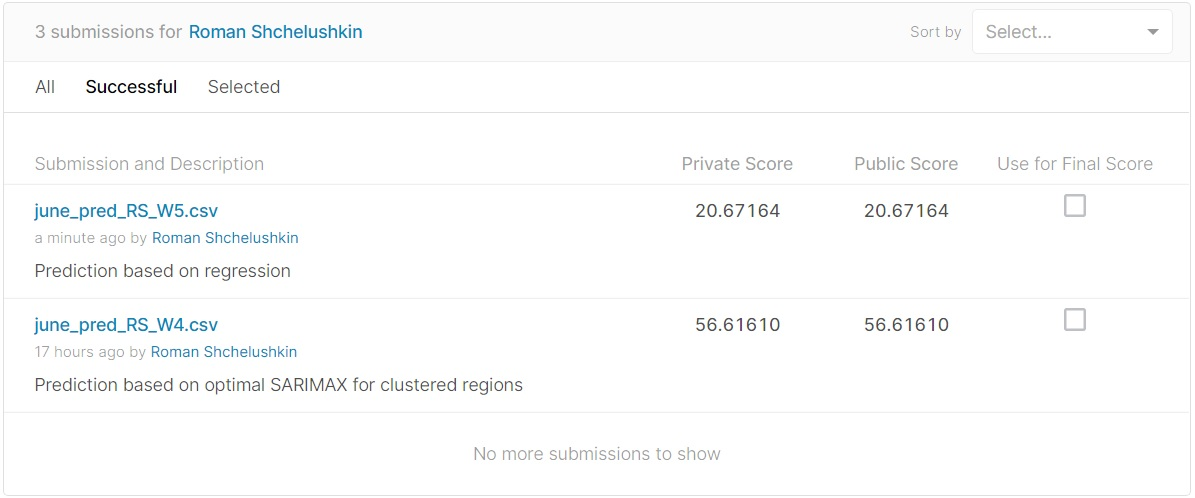

In [28]:
from IPython.display import Image
Image("img/Submission_KAGGLE_W5.jpg")